# Analysis of Global Production Crops Over Time

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from numpy import mean
sns.set_theme(style="darkgrid")


In [2]:
# parent directory
parent = os.path.dirname(os.getcwd())

# load main csv
wine = pd.read_csv("faostat_wine.csv")
temp = pd.read_csv("FAOSTAT_temp_change.csv")
#rain = pd.read_csv("")

## Data Exploration and Cleaning

In [3]:
#wine.head()
temp.head()
#wine.columns

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,Unit,Value,Flag,Flag Description
0,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1961,1961,°C,0.837,E,Estimated value
1,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1962,1962,°C,-0.296,E,Estimated value
2,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1963,1963,°C,-0.948,E,Estimated value
3,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1964,1964,°C,0.030,E,Estimated value
4,ET,Temperature change,250,France,7271,Temperature change,7020,Meteorological year,1965,1965,°C,-0.622,E,Estimated value


In [4]:
# Confirm only one unit in dataset
set(wine["Unit"].unique())

{'tonnes'}

In [5]:
# Set datatype of Year column to datetime
wine["Year Code"] = pd.to_datetime(wine["Year Code"],format="%Y")
temp["Year Code"] = pd.to_datetime(temp["Year Code"],format="%Y")

# Remove rows with null values in "value" column
wine = wine[wine["Value"].notna()]
temp = temp[temp["Value"].notna()]

# Remove unnecessary columns
wine = wine[["Area","Year Code","Value"]]
temp = temp[["Area","Year Code","Value"]]

In [6]:
wine.head(10)

,Area,Year Code,Value
0,France,1961-01-01,4855300.0
1,France,1962-01-01,7497000.0
2,France,1963-01-01,5752370.0
3,France,1964-01-01,6243200.0
4,France,1965-01-01,6841720.0
5,France,1966-01-01,6225340.0
6,France,1967-01-01,6202620.0
7,France,1968-01-01,6646030.0
8,France,1969-01-01,5128960.0
9,France,1970-01-01,7540180.0


In [7]:
print("ok")

ok


In [8]:
temp.head(10)

,Area,Year Code,Value
0,France,1961-01-01,0.837
1,France,1962-01-01,-0.296
2,France,1963-01-01,-0.948
3,France,1964-01-01,0.030
4,France,1965-01-01,-0.622
5,France,1966-01-01,0.421
6,France,1967-01-01,0.492
7,France,1968-01-01,-0.079
8,France,1969-01-01,0.017
9,France,1970-01-01,-0.104


Stationarity 

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

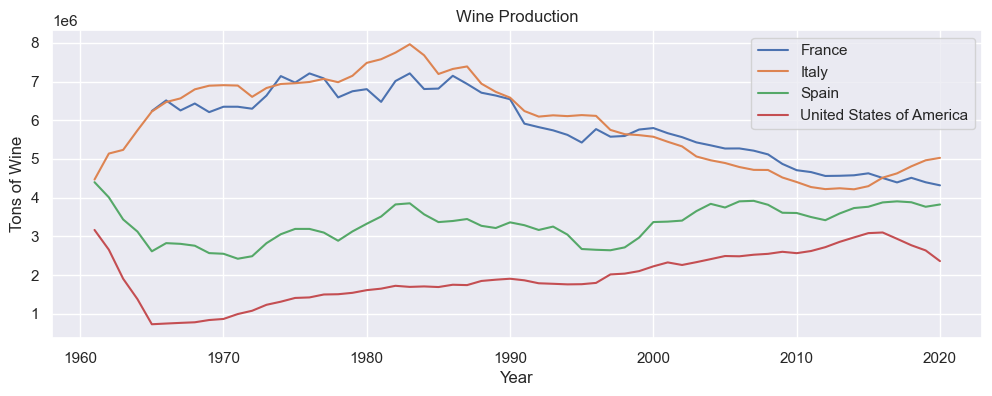

NameError: name 'df' is not defined

In [9]:
# Stationarity
fig = plt.figure()
fig.set_size_inches(12,4)
sns.lineplot(data=wine, x="Year Code", y=wine['Value'].rolling(5).mean(), hue="Area")
plt.title('Wine Production')
plt.xlabel('Year')
plt.ylabel('Tons of Wine')

plt.legend()
plt.show()


sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

In [ ]:
rolling_window = 5
for country in list(wine['Area'].unique()):
    f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

    sns.lineplot(x=wine["Year Code"], y=df.Rainfall, ax=ax[0, 0], color='indianred')
    sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
    sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
    ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
    ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

In [ ]:
from statsmodels.tsa.stattools import adfuller

def visual_stationarity(column):
    mean = column.rolling(window = 5).mean()
    std = column.rolling(window = 5).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    orig = plt.plot(column, color='pink',label='Original')
    mean = plt.plot(mean, color='b', label='Rolling Mean')
    std = plt.plot(std, color='g', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(loc='best')
    plt.show()plt.show()

C:\Users\jorda\AppData\Local\Temp\ipykernel_20212\633728411.py:3: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Area', 'Year Code'], dtype='object')
  mean = df_country.rolling(window = 5).mean()
C:\Users\jorda\AppData\Local\Temp\ipykernel_20212\633728411.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Area', 'Year Code'], dtype='object')
  std = df_country.rolling(window = 5).std()


TypeError: unhashable type: 'numpy.ndarray'

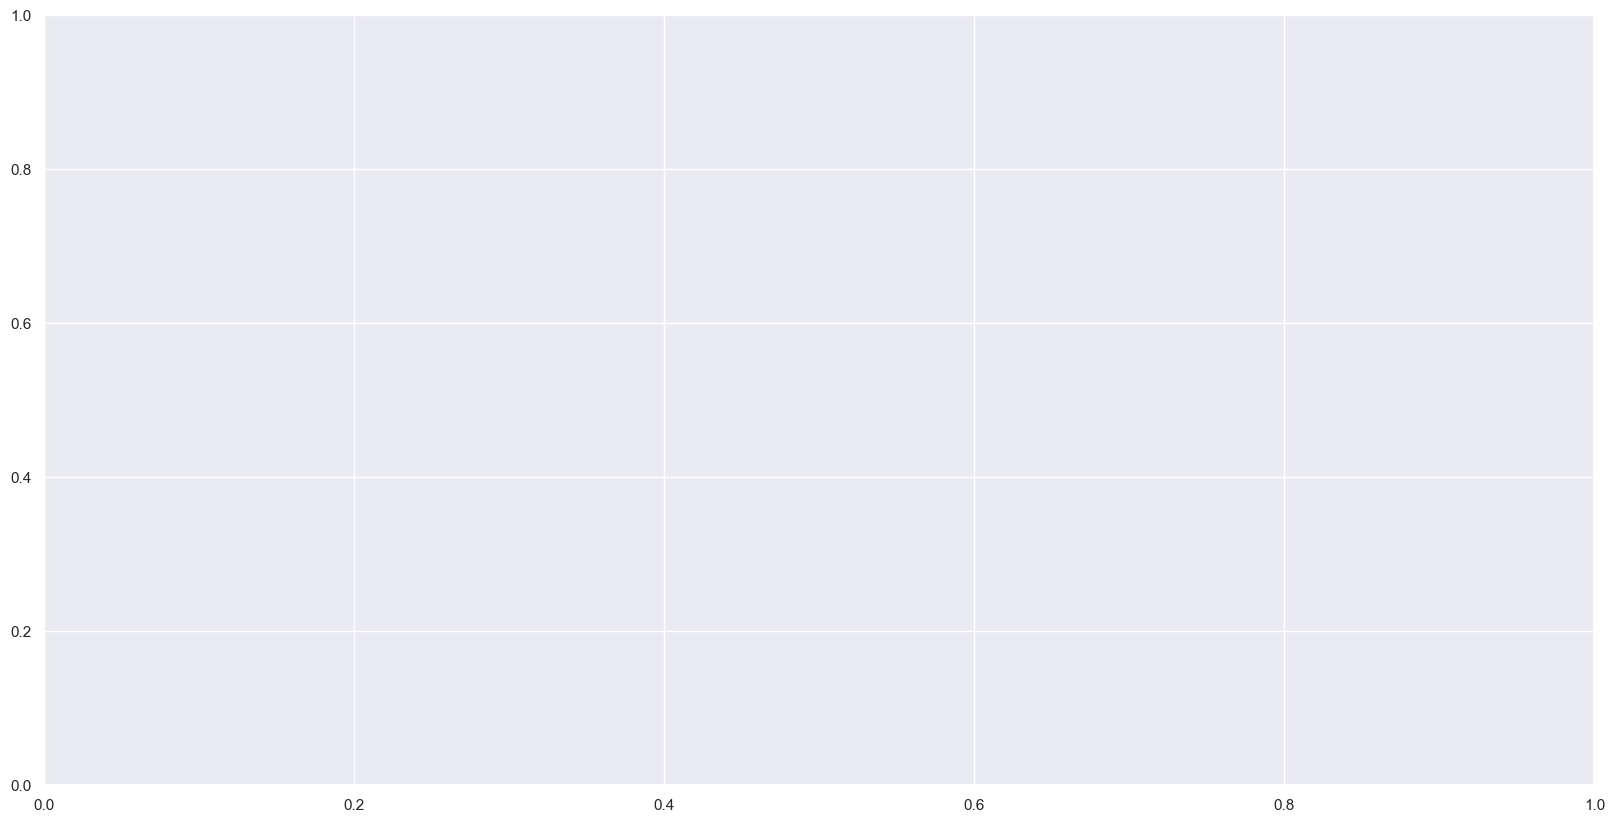

In [ ]:
for country in list(wine['Area'].unique()):
    df_country = wine.loc[wine['Area'] == country].copy()
    mean = df_country.rolling(window = 5).mean()
    std = df_country.rolling(window = 5).std()

    plt.figure(figsize=(20,10))
    orig = plt.plot(df_country, color='pink',label='Original')
    mean = plt.plot(mean, color='b', label='Rolling Mean')
    std = plt.plot(std, color='g', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend(loc='best')
    plt.show()

In [ ]:
for country in list(wine['Area'].unique()):
    result = adfuller(wine[wine['Area'] == country]['Value'].values)
    print(f"{country} P-value: ", result[1])

France P-value:  0.7953154797917146
Italy P-value:  0.39445511830085606
Spain P-value:  7.061830870711466e-05
United States of America P-value:  0.3649051796358107


In [ ]:
df_country = wine.loc[wine['Area'] == 'Italy', :].copy()
mean = df_country.rolling(window = 5).mean()